# Plotting codes for Fig S13

This notebook generate Fig. S13 of 

Myung J, Schmal C, Hong S, Tsukizawa Y, Rose P, Zhang Y, Holtzman MJ, De Schutter E, Herzel H (2018) The Choroid Plexus is an Important Circadian Clock Component. *Nat Commun*, *in press*.

It is written in [Julia language](https://julialang.org) and depends on MATLAB, PyPlot, and PyCall modules.

*Written by Sungho Hong, Computational Neuroscience Unit, Okinawa Institute of Science and Technology, Japan*

*Correspondence: Sungho Hong (shhong@oist.jp)*

*February 9, 2018*



In [1]:
using MATLAB
using PyPlot
using PyCall

rc("pdf", fonttype=42)
rc("mathtext", fontset="stix")

In [2]:
"""
    sync_index(z) 

Computes the synchronization index.
"""
function sync_index(z)
    nz = z./abs.(z);
    abs.(mean(nz,2))
end


@pyimport scipy.spatial.distance as dist
"""
    make_wij(xydim, radius)

Computes an adjacency matrix of a network with a 2d 
box geometry with `xydim`, based on the distance, `radius`.
"""
function make_wij(xydim, radius)
    ncell = prod(xydim)
    position = zeros(ncell, 2);
    count = 1;
    for y=0:(xydim[2]-1)
        for x=0:(xydim[1]-1)
            position[count, 1] = x
            position[count, 2] = y
            count = count+1
        end
    end

    dw = dist.pdist(position)
    dw = Float64.(dw .<= radius)
    sparse(dist.squareform(dw))
    
end


"""
    fMoranICirc(z, wij)

Computes Moran's *I* from the data `z` and adjacency matrix,
`wij`.
"""
function fMoranICirc(zin, wij)
    z = zin./abs.(zin)
    wijc = Complex.(wij)
    zm = mean(z, 2)
    zd = broadcast(-, z, zm)
    wdd = zeros(size(zd,1), 1)
    for i=1:length(wdd)
        dth = zd[i,:]
        wdd[i] = real(dth'*wijc*dth)
    end

    wdd./(1-abs.(zm).^2)/sum(sum(wij))
end


fMoranICirc

In [3]:
# Assume that the simulated data is saved as in "Simulation_Fig_S13.m".
mf = MatFile("fig_s13_data.mat")
res = get_variable(mf, "res")
qss = get_variable(mf, "qss")

z0 = res[1];
z1 = res[2];
q0 = sync_index(z0);
q1 = sync_index(z1);

nx = 48
ny = 16
wij = make_wij([nx,ny], 1)
mi0 = fMoranICirc(z0, wij)
mi1 = fMoranICirc(z1, wij)

q = qss[1];

wc = make_wij([48,16], 4)
zc = 0.0005/0.025*mean(sum(wc,2))+1;

## Plotting Fig S13a

i = 1464, ieqv = 1075
q0 = 0

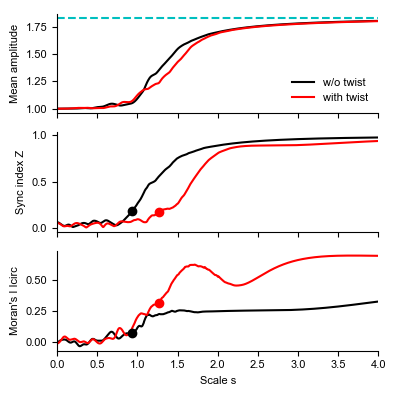

.178, q1 = 0.177
i = 1680, ieqv = 1127
q0 = 0.232, q1 = 0.231


In [4]:
tt = 1:size(z0,1)

i1 = 61*24
i2 = 70*24
fieqv = i -> maximum(tt[q0[:] .< q1[i]])+1;
ieqv1 = fieqv(i1);
ieqv2 = fieqv(i2);

println("i = $i1, ieqv = $ieqv1")
@printf("q0 = %.3f, q1 = %.3f\n", q0[ieqv1], q1[i1])
println("i = $i2, ieqv = $ieqv2")
@printf("q0 = %.3f, q1 = %.3f\n", q0[ieqv2], q1[i2])

fig, ax = subplots(nrows=3, ncols=1, sharex=true, figsize=[4, 4])
ax[1][:plot](q, mean(abs.(z0),2), "k", label="w/o twist")
ax[1][:plot](q, mean(abs.(z1),2), "r", label="with twist")
ax[1][:legend](["w/o twist", "with twist"], frameon=false, loc=4)
ax[1][:plot]([0, 4], [zc, zc], "--c")
ax[2][:plot](q, q0,"k", q, q1, "r")
ax[2][:plot](q[ieqv1], q0[ieqv1], "ok", q[i1], q1[i1], "or" )
ax[3][:plot](q, mi0,"k", q, mi1, "r")
ax[3][:plot](q[ieqv1], mi0[ieqv1], "ok", q[i1], mi1[i1], "or" )

for a in ax
    a[:set_xlim]([0, 4])
end
ax[1][:set_ylabel]("Mean amplitude")
ax[2][:set_ylabel]("Sync index Z")
ax[3][:set_ylabel]("Moran's I Icirc")
ax[3][:set_xlabel]("Scale s")
tight_layout()
savefig("stats_simulation40_TwistedVsNontwisted.pdf", dpi=1200)

## Plotting Fig S13b

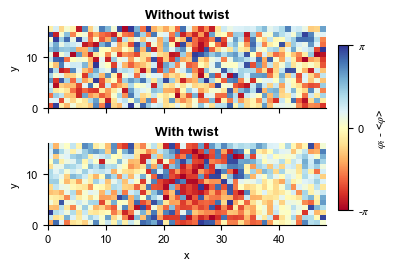

In [6]:
function phase_dev(z)
    ez = z;
    ez = ez./abs.(ez);
    ez = exp(-1im*(angle(mean(ez)))).*ez;
    p = (angle.(ez));
    reshape(p, nx, ny)'
end

function plot_phase_dev(ax, p, title)
    c = ax[:pcolor](p, cmap="RdYlBu", vmin=-pi, vmax=pi)
    ax[:set_title](title,fontweight="bold")
    ax[:set_ylabel]("y")
    c
end


p0 = phase_dev(z0[ieqv1,:]);
p1 = phase_dev(z1[i1,:]);

fig, ax = subplots(nrows=2, ncols=1, sharex=true, figsize=[4, 2.75]);
c1 = plot_phase_dev(ax[1], p0, "Without twist");
c2 = plot_phase_dev(ax[2], p1, "With twist");
ax[2][:set_xlabel]("x")
tight_layout()
subplots_adjust(right=0.82)
cax = axes([0.85, 0.225, 0.025, 0.6]);
cbar = colorbar(c1, cax=cax, ticks=[-pi, 0, pi]);
cbar[:ax][:set_yticklabels]([L"-$\pi$", "0", L"$\pi$"])  
cbar[:set_label](L"$\varphi_i$ - <$\varphi$>")
savefig("phasedev_simulation40_TwistedVsNontwisted.pdf", dpi=1200)